In [1]:
import scanpy as sc
import sys
sys.path.append('/wsfish/glioblastoma/')
import FISHspace as sp
from scipy.spatial import KDTree
import numpy as np
import squidpy as sq
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

# make font changeable in Illustrator
mpl.rcParams['pdf.fonttype'] = 42

# save figure with no pad
mpl.rcParams['savefig.pad_inches'] = 0
mpl.rcParams['savefig.bbox'] = 'tight'

# set axes width
mpl.rcParams['axes.linewidth'] = 0.2
mpl.rcParams['xtick.minor.pad'] = 0
mpl.rcParams['xtick.major.pad'] = 0
mpl.rcParams['ytick.minor.pad'] = 0
mpl.rcParams['ytick.major.pad'] = 0
mpl.rcParams['xtick.minor.width'] = 0.2
mpl.rcParams['xtick.major.width'] = 0.2
mpl.rcParams['ytick.minor.width'] = 0.2
mpl.rcParams['ytick.major.width'] = 0.2

# use colorblind seaborn style

In [2]:
adata = sc.read_h5ad('../GBM_Linnarsson_EEL.h5ad')
#adata_tumor_sc.X = adata_tumor_sc.layers['smooth']

In [4]:
rename_dic = {
    'GW-like 5':'GW-like Endo.Ass.',
    'GW-like 2':'GW-like Periphery1',
    'GW-like 3':'GW-like Periphery2',
    'GW-like 1':'GW-like Periphery3',
    
    'GW-like 6':'GW-like HYPR1',
    'GW-like 8':'GW-like HYPR2',
    'GW-like 7':'GW-like OPC',
    'GW-like 4':'GW-like nIPC',
    
    'nIPC-RG-like':'RG-like',
    
 
}

adata.obs['m-states3'] = pd.Categorical([rename_dic[m] if m in rename_dic else m for m in adata.obs['m-states2']])
adata.obs['m-states3'] = ['Endothelial' if ms.count('Endothelial') else ms for ms in adata.obs['m-states3']]
adata.obs['m-states3'] = ['Oligodendrocyte' if ms.count('Oligodendrocyte') else ms for ms in adata.obs['m-states3']]
adata.obs['m-states3'] = pd.Categorical(['Mural cell' if ms.count('Mural') else ms for ms in adata.obs['m-states3']])

In [5]:
adata.obs['m-states3'].cat.categories

Index(['AC-like 1', 'AC-like 2', 'AC-like 3', 'AC-like 4', 'AC-like 5',
       'AC-like 6', 'AC-like 7', 'Astrocyte', 'DC', 'Endothelial',
       'Erythrocyte 1', 'FB-like 1', 'FB-like 2', 'FB-like 3', 'GBL-like 1',
       'GBL-like 2', 'GW-like Endo.Ass.', 'GW-like HYPR1', 'GW-like HYPR2',
       'GW-like OPC', 'GW-like Periphery1', 'GW-like Periphery2',
       'GW-like Periphery3', 'GW-like nIPC', 'Mono 1', 'Mono 2', 'Mural cell',
       'OPC-like 1', 'OPC-like 2', 'Oligodendrocyte', 'RG-like', 'TAM-BDM 1',
       'TAM-BDM 2', 'TAM-BDM 3', 'TAM-BDM 4', 'TAM-MG', 'nIPC-like 1',
       'nIPC-like 2', 'nIPC-like 3', 'preOPC-like 1', 'unknown 1',
       'unknown2 1'],
      dtype='object')

In [61]:
palette = {
    'AC-like 1':'#2ecc71',#inchworm B4FF9F
    'AC-like 2':'#2ecc71',#inchworm B4FF9F
    'AC-like 3':'#2ecc71',#inchworm B4FF9F
    'AC-like 4':'#2ecc71',#inchworm B4FF9F
    'AC-like 5':'#2ecc71',#inchworm B4FF9F
    'AC-like 6':'#2ecc71',#inchworm B4FF9F
    'AC-like 7':'#2ecc71',#inchworm B4FF9F
    'AC-like 8':'#2ecc71',#inchworm B4FF9F

    'preOPC-like 1':'#7befb2',#'#c2f970'

    'GW-like Endo.Ass.':'#e76d89',# Deep cerise
    'GW-like Periphery1':'#e76d89',# Deep cerise
    'GW-like Periphery2':'#e76d89',# Deep cerise
    'GW-like Periphery3':'#e76d89',# Deep cerise
    'GW-like HYPR1':'#e76d89',# Deep cerise
    'GW-like HYPR2':'#e76d89',# Deep cerise
    'GW-like nIPC':'#e76d89',# Deep cerise
    'GW-like OPC':'#e76d89',# Deep cerise
    
    #'nIPC-like 1':'#FFF192',
    #'nIPC-like 2':'#FFF192',
    #'nIPC-like 3':'#FFF192',
    
    'RG-like':'#ff9470',
    'nIPC-RG-like':'#ff9470',
    
    'OPC-like 1':'#89c4f4', #bright turquoise
    'OPC-like 2':'#89c4f4', #bright turquoise
    
    'TAM-BDM 1':'#e3ba8f', #wood
    'TAM-BDM 2':'#e3ba8f',
    'TAM-BDM 3':'#e3ba8f',
    'TAM-BDM 4':'#e3ba8f', #wood

    'TAM-MG':'#a6915c',#red orange
    'Mono 1': '#f4ede4',
    'Mono 2': '#f4ede4',
    
    'Oligodendrocyte':'#392e4a',
    'Astrocyte':'#038aff',
    
    #'Endothelial':'#d5b8ff', #mauve
    #'Mural cell': '#8c14fc',  #electric indigo
    #'Mural': '#8c14fc',  #electric indigo
    'Endothelial':'#d5b8ff', #mauve
    #'Mural cell': '#8c14fc',  #electric indigo
    'Mural cell': '#8c14fc',  #electric indigo
    
    #'Fibroblast': '#fbe7ef',
     #'FB-like 1': '#FF6EC7', #fff9de
    'FB-like 2': '#FF6EC7', #fff9de
    'FB-like 3': '#FF6EC7', #fff9de
    
}

# All Samples

In [7]:
'''dic_nhood = {} 
samples = []
for s in adata.obs.Sample.cat.categories:
    print(s)
    
    sadata = adata[adata.obs.Sample == s]
    sadata = sadata[sadata.X.sum(axis=1) > 20]
    selected_clusters = list(palette.keys())
    sadata_clusters = sadata[sadata.obs['m-states3'].isin(selected_clusters)]
    if len(sadata_clusters.obs['m-states3'].cat.categories) > 7:

        #try:
        #kdT = KDTree(sadata.obsm['spatial'])
        #d,i = kdT.query(sadata.obsm['spatial'],k=10)
        #d_th = np.percentile(d[:,-1],95)

        sq.gr.spatial_neighbors(sadata_clusters,coord_type="generic", n_neighs=10,delaunay=True,radius=(2.5,50))
        sq.gr.nhood_enrichment(sadata_clusters, cluster_key="m-states3")

        sp.pl.neighborhood_enrichment(
            sadata_clusters, 
            key='m-states3',
            palette=palette,
            save=True,
            figsize=(7,7),
            savepath=f'figures/figures_nn/NN_{s}.pdf'
        )

        df = pd.DataFrame(
        data=sadata_clusters.uns['m-states3_nhood_enrichment']['zscore'], 
        index=sadata_clusters.obs['m-states3'].cat.categories,
        columns=sadata_clusters.obs['m-states3'].cat.categories,

        )

        full_df = pd.DataFrame(np.zeros([len(selected_clusters), len(selected_clusters)]), index=selected_clusters, columns=selected_clusters)
        for s1 in selected_clusters:
            for s2 in selected_clusters:
                try:
                    v = df[s1][s2]
                except:
                    v = 0
                full_df[s1][s2] = v
        dic_nhood[s] = full_df
        samples.append(s)
        #except:
        #    print(f'Could not analyse sample {s}')
            

'''

'dic_nhood = {} \nsamples = []\nfor s in adata.obs.Sample.cat.categories:\n    print(s)\n    \n    sadata = adata[adata.obs.Sample == s]\n    sadata = sadata[sadata.X.sum(axis=1) > 20]\n    selected_clusters = list(palette.keys())\n    sadata_clusters = sadata[sadata.obs[\'m-states3\'].isin(selected_clusters)]\n    if len(sadata_clusters.obs[\'m-states3\'].cat.categories) > 7:\n\n        #try:\n        #kdT = KDTree(sadata.obsm[\'spatial\'])\n        #d,i = kdT.query(sadata.obsm[\'spatial\'],k=10)\n        #d_th = np.percentile(d[:,-1],95)\n\n        sq.gr.spatial_neighbors(sadata_clusters,coord_type="generic", n_neighs=10,delaunay=True,radius=(2.5,50))\n        sq.gr.nhood_enrichment(sadata_clusters, cluster_key="m-states3")\n\n        sp.pl.neighborhood_enrichment(\n            sadata_clusters, \n            key=\'m-states3\',\n            palette=palette,\n            save=True,\n            figsize=(7,7),\n            savepath=f\'figures/figures_nn/NN_{s}.pdf\'\n        )\n\n      

In [35]:
import pickle
dic_nhood = pickle.load(open('../Fig4/CellStateNN_20240528.pkl', 'rb'))

In [36]:
from sklearn.preprocessing import StandardScaler, Normalizer, MinMaxScaler, RobustScaler
import scipy.cluster.hierarchy as hc
from scipy.spatial.distance import pdist
from sklearn.preprocessing import scale
from scipy.cluster.hierarchy import dendrogram
import fastcluster

mutation_df = pd.read_parquet('../../MutationLandscape/MutationsPatients2.parquet')
import seaborn as sns
_palette = sns.color_palette("hls", mutation_df.shape[1])
paletteMutations = {}
for col, gene in zip(_palette, mutation_df.columns):
    paletteMutations[gene] = col
'''for m, col in paletteMutations.items():
    print(m , mpl.colors.to_hex(col))'''

'for m, col in paletteMutations.items():\n    print(m , mpl.colors.to_hex(col))'

In [ ]:
dic_nhood['SL005'].replace([np.inf, -np.inf, np.nan], 0)

,AC-like 1,AC-like 2,AC-like 3,AC-like 4,AC-like 5,AC-like 6,AC-like 7,AC-like 8,preOPC-like 1,GW-like Endo.Ass.,...,TAM-BDM 3,TAM-BDM 4,TAM-MG,Mono 1,Mono 2,Oligodendrocyte,Astrocyte,Endothelial,FB-like 2,FB-like 3
AC-like 1,-0.031639,0.0,-0.077693,0.0,-0.105463,1.019048,0.102157,0.0,-0.302129,-0.272355,...,-0.201452,-0.110208,0.0,-0.553957,0.0,4.940490,-0.241406,0.156258,-0.522053,0.0
AC-like 2,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
AC-like 3,-0.077693,0.0,0.000000,0.0,-0.119159,-0.737520,-1.115532,0.0,-0.394633,-0.297241,...,-0.272679,-0.110208,0.0,0.999700,0.0,-1.063602,-0.334995,-0.115005,-0.612506,0.0
AC-like 4,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
AC-like 5,-0.105463,0.0,-0.119159,0.0,-0.083960,-0.714325,-0.255096,0.0,-0.354579,-0.275276,...,-0.264139,-0.095298,0.0,-0.597798,0.0,-1.036349,-0.338022,-1.019160,1.004170,0.0
AC-like 6,1.019048,0.0,-0.737520,0.0,-0.714325,-2.333483,-3.127479,0.0,1.734451,-2.018849,...,-0.380362,-0.750737,0.0,-4.259715,0.0,1.955811,-0.755252,0.883913,0.865308,0.0
AC-like 7,0.102157,0.0,-1.115532,0.0,-0.255096,-3.127479,6.235496,0.0,-2.778011,-2.127948,...,-1.625231,-1.220615,0.0,27.955752,0.0,-3.612760,-0.543698,-4.447292,-0.468768,0.0
AC-like 8,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
preOPC-like 1,-0.302129,0.0,-0.394633,0.0,-0.354579,1.734451,-2.778011,0.0,-0.997123,-1.091555,...,-0.013973,-0.432259,0.0,-1.193679,0.0,-1.380166,-0.485618,-1.954893,-1.351857,0.0
GW-like Endo.Ass.,-0.272355,0.0,-0.297241,0.0,-0.275276,-2.018849,-2.127948,0.0,-1.091555,-0.548348,...,-0.744285,-0.309291,0.0,-1.204082,0.0,0.198036,-0.933025,0.401624,1.878577,0.0


In [38]:
df_samples = pd.DataFrame(
    data=np.array(
        [
            #StandardScaler().fit_transform(dic_nhood[k].fillna(0).values).flatten() for k in dic_nhood
            StandardScaler().fit_transform(dic_nhood[k].replace([np.inf, -np.inf, np.nan], 0)).flatten() for k in dic_nhood
            #dic_nhood[k].values.flatten() for k in dic_nhood
        ]
    ).T, 
    columns=list(dic_nhood.keys())
)

#X = StandardScaler().fit_transform(df_samples.values.T)
#df_samples = pd.DataFrame(data=X.T, index=df_samples.index, columns=df_samples.columns)

In [39]:
metric = 'cosine'
method = 'ward'
D = pdist(df_samples.dropna().T, metric=metric)
#D[np.isnan(D)] = 0
Z = fastcluster.linkage(D, method=method, metric=metric, preserve_input=True)
Z = hc.optimal_leaf_ordering(Z, D, metric=metric)
ordering_samples = hc.leaves_list(Z)

In [40]:
samples = list(dic_nhood.keys())


organization = {
        'GBM': ['IDH', '1p19q'],
        'RTK': ['PIK3','EGFRamp', 'EGFRmut', 'PDGFRA', 'PDGFA', 'PTEN', 'NF1'],
        'p53': ['p53', 'MDM'],
        'RB':['RB1','CDK2NA/B','CDK'],
        'Other':['DNMT3A','MGMT','TERT','GLI1','MET']
                }

mutation_loc = [
    'IDH', '1p19q', 
    'PIK3','EGFRamp', 'EGFRmut', 'PDGFRA', 'PDGFA', 'PTEN', 'NF1',
    'p53', 'MDM',
    'RB1','CDK2NA/B','CDK',
    'DNMT3A','MGMT','TERT','GLI1','MET',
]


paletteMutations = {}
#for col, gene in zip(_palette, mutation_df.columns):
#    paletteMutations[gene] = col
#for m in organization:
#    
_palette = sns.color_palette("hls", mutation_df.shape[1]+2)
print(len(_palette), len(mutation_loc))
for c, m in zip(_palette, mutation_loc):
    #print(c,m)
    paletteMutations[m] = c
mutation_df = mutation_df.loc[:,mutation_loc]

21 19


INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 26 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'L', 'S', 'eight', 'five', 'four', 'k', 'l', 'nine', 'nonmarkingreturn', 'one', 'seven', 'six', 'space', 'three', 'two', 'u', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 36, 37, 38, 39, 40, 41, 42, 47, 54, 78, 79, 88]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 26 glyphs after
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'L', 'S', 'eight', 'five', 'four', 

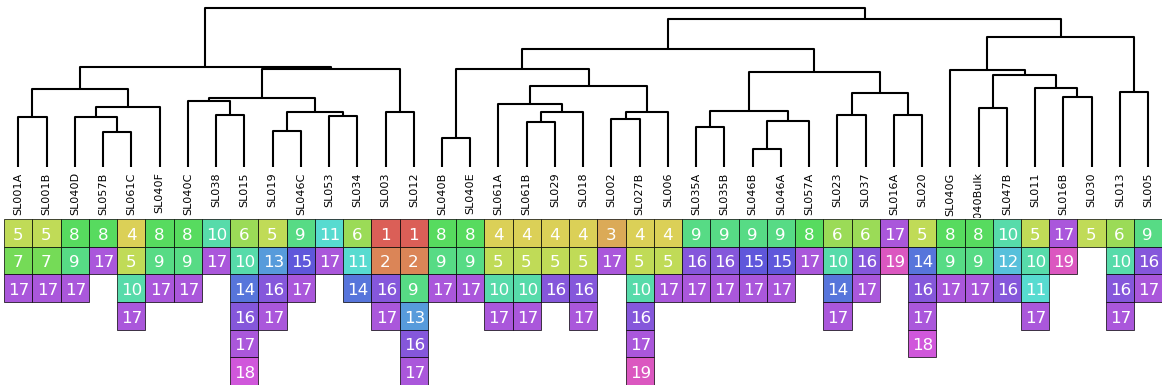

In [42]:
from matplotlib.patches import Rectangle
figsize = (15,5)
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=figsize, sharex=True,gridspec_kw={'hspace':0.3}, height_ratios=(2,2))

ax = axs[0]
samples = np.array(samples)
out = dendrogram(Z,labels=df_samples.columns, ax = ax, above_threshold_color='black', color_threshold=0)
spines = ["top","right","left","bottom"]
for s in spines:
    ax.spines[s].set_visible(False)
ax.set_yticks([])
ax = axs[1]

for i,s in enumerate(samples[ordering_samples]):
    patient = s[:5]
    mut = mutation_df.loc[patient]
    mut = mut[mut != 0].index.tolist()
    for c, m in enumerate(mut):
        #loc = mutation_loc.index(m)
        #ax.scatter(i*10+5, loc,marker='s', s=150, color=paletteMutations[m])
        ax.add_patch(Rectangle(
            xy=(i*10, c*10) ,width=10, height=10,fill=True,edgecolor='black',facecolor = paletteMutations[m],#color=paletteMutations[m], 
            linewidth=.5, )
            )
        
        if mutation_loc.index(m)+1 > 9:
            extra=1.5
        else:
            extra = 3
        ax.annotate(
            text=mutation_loc.index(m)+1, xy=(i*10+extra, c*10+7.5),fontsize=12,color='white',
            )
            
ax.set_yticks([])
#ax.set_xticks([])
spines = ["top","right","left","bottom"]
for s in spines:
    ax.spines[s].set_visible(False)
ax.invert_yaxis()   
ax.set_xlim(-.1*figsize[0], len(ordering_samples)*10+.1)
ax.set_ylim((len(mutation_loc)+1)*3, -.5)
#plt.setp(axs[0].get_xticklabels(),visible=True, color="r")
axs[0].tick_params(labelbottom=True)
axs[1].tick_params(labelbottom=False)
plt.tight_layout()
plt.savefig('figures/NNconservation.pdf',dpi=150,transparent=True)

In [45]:
noMES = ['SL040D', 'SL001A', 'SL001B', 'SL057B', 'SL061C', 'SL040F', 'SL015', 'SL040C', 'SL038','SL053', 'SL034', 'SL012', 'SL003' ]
MES = [s for s in samples if s not in noMES]



In [63]:
tumor_and_endo = [
    'AC-like 1', 'AC-like 2', 'AC-like 3', 'AC-like 4', 'AC-like 5', 'AC-like 6', 'AC-like 7', 
    'preOPC-like 1', 
    #'GW-like Endo.Ass.', 'GW-like Periphery1', 'GW-like Periphery2', 'GW-like Periphery3', 'GW-like HYPR1', 'GW-like HYPR2', 'GW-like nIPC', 'GW-like OPC', 
    'RG-like', 'nIPC-RG-like', 
    'OPC-like 1', 'OPC-like 2', 
    #'TAM-BDM 1', 'TAM-BDM 2', 
    #'TAM-BDM 3', 'TAM-BDM 4', 'TAM-MG', 'Mono 1', 'Mono 2', 
    #'Oligodendrocyte', 
    #'Astrocyte', 
    'Endothelial',
    'Mural cell',
    'FB-like 2', 'FB-like 3'
]

In [68]:
dics = pickle.load(open('../../CellStateNN_20230703.pkl','rb'))
dics = dic_nhood

TypeError: Argument 'placement' has incorrect type (expected pandas._libs.internals.BlockPlacement, got slice)

In [ ]:
dic_nhood['SL035B'].columns

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:FFTM dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 37 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'A', 'B', 'C', 'E', 'F', 'G', 'I', 'O', 'P', 'R', 'a', 'd', 'e', 'eight', 'five', 'four', 'h', 'hyphen', 'i', 'k', 'l', 'minus', 'n', 'nonmarkingreturn', 'o', 'one', 'p', 'r', 'seven', 'six', 'space', 't', 'three', 'two', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 16, 19, 20, 21, 22, 23, 24, 25, 26, 27, 36, 37, 38, 40, 41, 42, 44, 50, 51, 53, 68, 71, 72, 75, 76, 78, 79, 81, 82, 83, 85, 87, 3228]
INFO:fontTools.subset:Closed glyph list over 'GSUB': 37 glyphs after
INFO:fontTools.subs

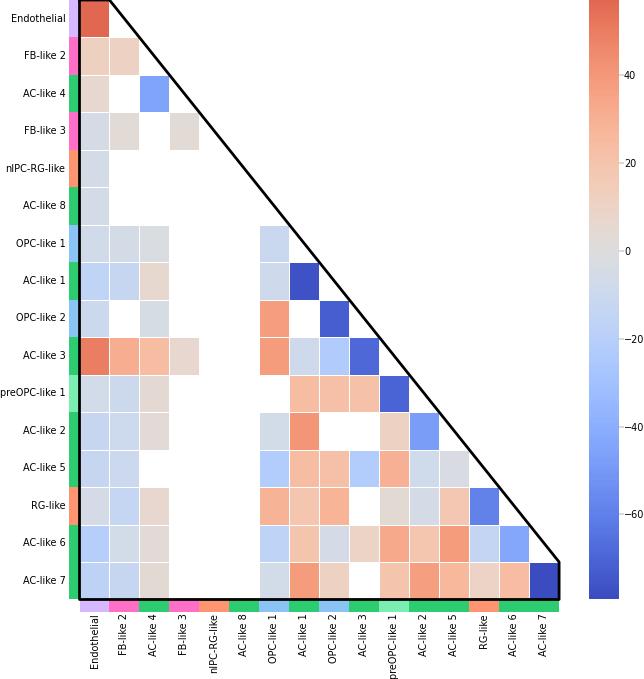

Index(['Endothelial', 'FB-like 2', 'AC-like 4', 'FB-like 3', 'nIPC-RG-like',
       'AC-like 8', 'OPC-like 1', 'AC-like 1', 'OPC-like 2', 'AC-like 3',
       'preOPC-like 1', 'AC-like 2', 'AC-like 5', 'RG-like', 'AC-like 6',
       'AC-like 7'],
      dtype='object')

In [65]:

from sklearn.preprocessing import StandardScaler, RobustScaler

classes0 = tumor_and_endo
classes0 = np.array(classes0)
classes = []
for s in dics:
    classes += dics[s].index.tolist()
classes = np.unique(np.array(classes))
classes = classes0[np.isin(classes0, classes)]
df0 = dics[list(dics.keys())[0]]
df0 = df0.loc[classes][classes]
vals = np.zeros_like(df0.values)

for x in samples:
    df = dics[x]  
    df = df.loc[classes][classes]
    #X = StandardScaler().fit_transform(df.values)
    X = StandardScaler().fit_transform(df.replace([np.inf, -np.inf, np.nan], 0))
    #X = StandardScaler().fit_transform(X.T).T
    vals += X

NN_all = pd.DataFrame(data=vals, columns=classes, index = classes)

sp.pl.neighborhood_enrichment_from_pandas(
    NN_all,
    palette=palette,
    save=True,
    figsize=(7,7),
    savepath=f'figures/NN_all.pdf',
    
)